In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [4]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")
macro = p.utc_date(macro)

In [6]:
factors = ["assets","liabilities","reference_price"]

In [25]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["cik"])
        price = market.query("prices",{"ticker":ticker})
        filings = sec.query("filings",{"cik":cik})
        if price.index.size > 0 and filings.index.size > 0:
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price.sort_values("date",inplace=True)
            price = Indicator.ROLLING_DOLLAR_VOLUME.calculate(price)
            filings = p.utc_date(filings).dropna()
            filings = p.lower_column(filings)
            filings = p.additional_date_columns(filings)
            ticker_factors = filings.drop(["date","month","week","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
            ticker_factors["year"] = ticker_factors["year"] + 1
            if ticker_factors.index.size > 0:
                ticker_factors["ticker"] = ticker
                ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
                ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
                factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","rolling_dollar_volume","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

4240it [03:00, 23.43it/s]


In [26]:
model_start = 2015
model_end = 2022
backtest_end = 2026
model = XGBRegressor(booster="gbtree",random_state=42)
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["ticker","year","quarter","prediction"]]

In [27]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.utc_date(market.query("prices",{"ticker":ticker}))
        price = p.additional_date_columns(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(sim,on=["year","quarter","ticker"],how="left")
        price = p.utc_date(price)
        price = price.merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = SingleIndexCAPM.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  0%|▋                                                                                                                                                                                            | 15/4240 [00:01<05:00, 14.04it/s]

'date'


  1%|█▌                                                                                                                                                                                           | 35/4240 [00:02<04:36, 15.23it/s]

'date'


  3%|█████▎                                                                                                                                                                                      | 119/4240 [00:08<04:23, 15.62it/s]

'date'


 11%|█████████████████████▌                                                                                                                                                                      | 485/4240 [00:39<04:40, 13.37it/s]

'date'
'date'


 12%|██████████████████████▎                                                                                                                                                                     | 504/4240 [00:40<05:04, 12.27it/s]

'date'


 12%|███████████████████████▎                                                                                                                                                                    | 526/4240 [00:42<03:29, 17.73it/s]

'date'


 14%|██████████████████████████▊                                                                                                                                                                 | 605/4240 [00:48<03:54, 15.48it/s]

'date'
'date'


 18%|█████████████████████████████████▍                                                                                                                                                          | 753/4240 [00:59<04:02, 14.35it/s]

'date'


 20%|█████████████████████████████████████▎                                                                                                                                                      | 841/4240 [01:07<04:37, 12.26it/s]

'date'


 22%|████████████████████████████████████████▍                                                                                                                                                   | 912/4240 [01:13<04:07, 13.43it/s]

'date'


 23%|██████████████████████████████████████████▊                                                                                                                                                 | 965/4240 [01:17<03:11, 17.09it/s]

'date'
'date'


 25%|██████████████████████████████████████████████▉                                                                                                                                            | 1065/4240 [01:25<03:37, 14.61it/s]

'date'


 38%|██████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1594/4240 [02:09<02:54, 15.13it/s]

'date'


 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1704/4240 [02:18<03:03, 13.79it/s]

'date'


 41%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1750/4240 [02:22<03:17, 12.59it/s]

'date'


 44%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1853/4240 [02:30<02:56, 13.56it/s]

'date'


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2209/4240 [02:59<02:22, 14.24it/s]

'date'


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2223/4240 [03:00<02:12, 15.26it/s]

'date'
'date'


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2427/4240 [03:17<02:06, 14.32it/s]

'date'


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2470/4240 [03:21<02:12, 13.33it/s]

'date'
'date'


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2602/4240 [03:32<01:59, 13.66it/s]

'date'


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 2678/4240 [03:38<01:40, 15.60it/s]

'date'


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2942/4240 [04:00<01:36, 13.51it/s]

'date'


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3560/4240 [04:49<00:47, 14.45it/s]

'date'


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3664/4240 [04:57<00:39, 14.61it/s]

'date'


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 3882/4240 [05:16<00:28, 12.68it/s]

'date'


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4136/4240 [05:37<00:08, 12.37it/s]

'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4240/4240 [05:45<00:00, 12.26it/s]


In [28]:
sim = pd.concat(prices)
sim.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'realtime_start', 'realtime_end',
       'rf', 'factor', 'risk', 'sigma'],
      dtype='object')

In [29]:
## getting names
simulation = pd.concat(prices).merge(index[["ticker","office"]],on="ticker",how="left")

## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'realtime_start', 'realtime_end',
       'rf', 'factor', 'risk', 'sigma', 'office', 'sell_price', 'sell_date'],
      dtype='object')

In [30]:
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'realtime_start', 'realtime_end',
       'rf', 'factor', 'risk', 'sigma', 'office', 'sell_price', 'sell_date'],
      dtype='object')

In [31]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.05],grouping_columns=["office"])

In [32]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [33]:
run = True
if run:
    analysises = []
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:37<00:00,  2.06s/it]


In [34]:
a = pd.DataFrame(analysises)
a.columns

Index(['timeframe', 'ranking_metric', 'position_type', 'selection_type',
       'selection_percentage', 'grouping_column', 'date', 'pnl', 'downside',
       'coefficient_of_variation', 'portfolio_std', 'average_gain',
       'average_loss', 'win_loss_ratio', 'weekly_return', 'sharpe_ratio',
       'portfolio'],
      dtype='object')

In [35]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

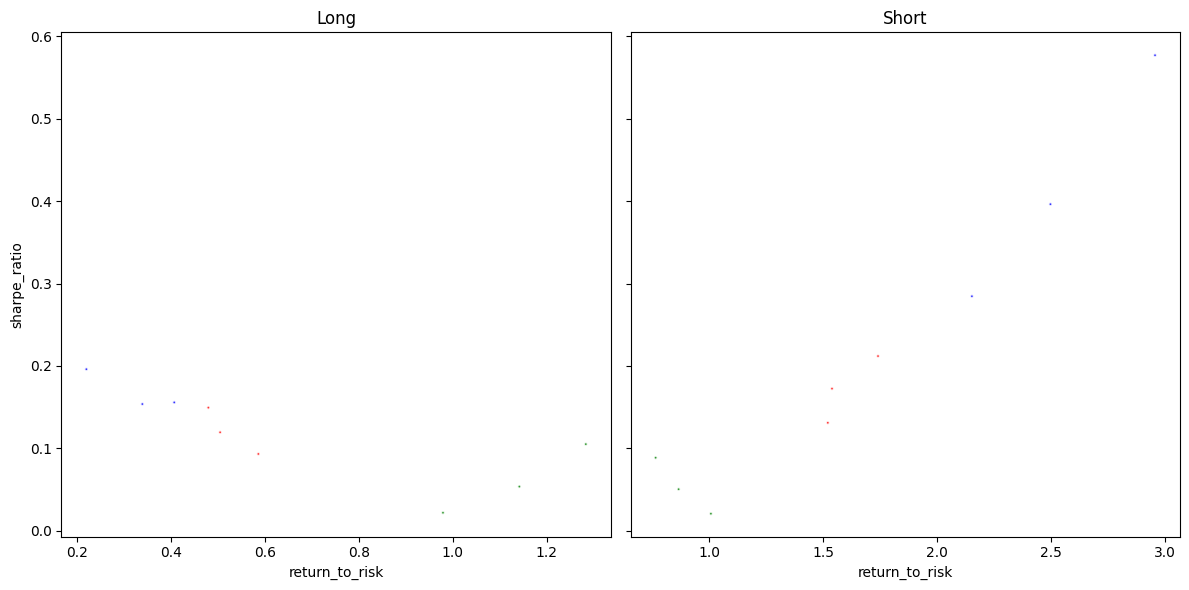

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["pnl"],
        d_analysis["portfolio_std"],
        c=d_analysis["color"],
        s=d_analysis["selection_percentage"] * 100,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [37]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,timeframe,ranking_metric,position_type,selection_type,selection_percentage,grouping_column,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
17,2.955212,quarter,factor,short,top,0.05,office,0.933267,0.204073,0.577086,1.256719,0.708548,0.630338,1.054081,1.818632,<financial_common.portfolio_management.portfol...,blue,5.120926
16,2.496781,month,factor,short,top,0.05,office,0.851584,0.072111,0.396329,1.153349,0.837044,0.594212,1.024997,1.888731,<financial_common.portfolio_management.portfol...,blue,6.299774
15,2.152520,week,factor,short,top,0.05,office,0.884564,0.032992,0.284589,1.062219,0.934738,0.555167,1.005511,1.782076,<financial_common.portfolio_management.portfol...,blue,7.563595
14,1.741056,week,factor,short,bottom,0.05,office,0.834815,0.038470,0.211985,1.065553,0.926629,0.556942,1.004002,0.451427,<financial_common.portfolio_management.portfol...,red,8.213088
13,1.539353,month,factor,short,bottom,0.05,office,0.756445,0.076908,0.172521,1.156065,0.815486,0.581350,1.013482,-1.210690,<financial_common.portfolio_management.portfol...,red,8.922710
12,1.520903,quarter,factor,short,bottom,0.05,office,0.866181,0.067922,0.131078,1.266170,0.678031,0.606756,1.034888,-2.935683,<financial_common.portfolio_management.portfol...,red,11.603035
11,1.282839,quarter,factor,long,mixed,0.05,office,1.000000,0.080397,0.105114,1.297236,0.706603,0.530274,1.019800,-5.925616,<financial_common.portfolio_management.portfol...,green,12.204229
10,1.141459,month,factor,long,mixed,0.05,office,0.905003,0.024820,0.053635,1.170650,0.834321,0.503108,1.003531,-11.312767,<financial_common.portfolio_management.portfol...,green,21.281875
9,1.008501,week,factor,short,mixed,0.05,office,0.938092,0.010550,0.020749,1.067998,0.927970,0.514908,1.000072,-30.693844,<financial_common.portfolio_management.portfol...,green,48.605418
8,0.978898,week,factor,long,mixed,0.05,office,0.944447,0.010540,0.021908,1.069192,0.929269,0.504987,0.999928,-30.421454,<financial_common.portfolio_management.portfol...,green,44.682994


In [38]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'quarter',
 'ranking_metric': 'factor',
 'position_type': 'short',
 'selection_type': 'top',
 'selection_percentage': 0.05,
 'grouping_column': 'office',
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 2.955212227880314,
 'downside': 0.9332669882869792,
 'coefficient_of_variation': 0.20407322329018376,
 'portfolio_std': 0.5770855589293122,
 'average_gain': 1.2567192792882742,
 'average_loss': 0.7085477814897694,
 'win_loss_ratio': 0.6303377947737412,
 'weekly_return': 1.0540809945698977,
 'sharpe_ratio': 1.8186321070056435,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x2371a9e9ed0>,
 'color': 'blue',
 'return_to_risk': 5.120925627325048}

In [39]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","office"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

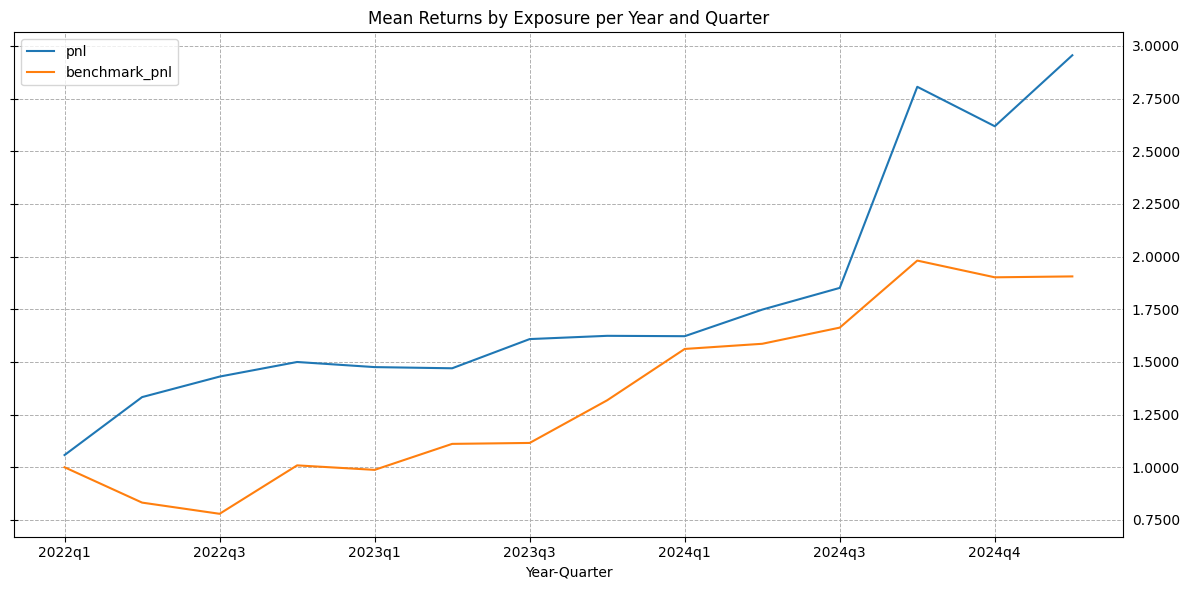

In [40]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [41]:
portfolio.tail()

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Quarter
9,2024-06-28 00:00:00+00:00,1.077770,1.748155,198.914903,1.586014,2024,6,2,26,2024q2
10,2024-09-30 00:00:00+00:00,1.058973,1.851248,208.537174,1.662736,2024,9,3,40,2024q3
11,2024-11-29 00:00:00+00:00,1.515474,2.805519,248.430657,1.980820,2024,11,4,48,2024q4
12,2024-12-31 00:00:00+00:00,0.933267,2.618298,238.472340,1.901419,2024,12,4,1,2024q4
13,2025-03-20 00:00:00+00:00,1.128677,2.955212,239.010000,1.905706,2025,3,1,12,2025q1


In [47]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False)

,return
office,
Office of Life Sciences,1.115939
Office of Finance or Office of Crypto Assets,1.095146
Office of Manufacturing,1.076633
Industrial Applications and Services,1.067929
Office of Technology,1.066465
Office of Real Estate & Construction,1.035686
Office of Trade & Services,1.033762
Office of Crypto Assets,1.030475
Office of Finance,1.008675
